In [1]:
!pwd

/Users/furiosa/Documents/repos/paper_greekparliament/src


In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import datetime
import re
import os
tqdm.pandas()
from cade.cade import CADE
from gensim.models.word2vec import Word2Vec
from scipy.spatial.distance import cosine, euclidean
from sklearn.metrics.pairwise import cosine_similarity
import tqdm.notebook as tq
from tabulate import tabulate


In [2]:
df = pd.read_csv('../out_files/tell_all_cleaned.csv')

print(df.shape)
df = df[df['speech'].notna()]
print(df.shape)
df.speech.iloc[0]


(1280918, 12)
(1274505, 12)


'παρακαλειται @sw γραμματεας βουλγαρακης @sw συνοδευσει @sw μακαριοτατο αρχιεπισκοπο αθηνων @sw πασης ελλαδος σεραφειμ @sw @sw συνοδευοντα @sw μελη @sw ιερας συνοδου @sw @sw εισοδο @sw @sw αιθουσα @sw βουλης @sw @sw τελεσθει αγιασμος.@sw συνεχεια τελειται @sw καθιερωμενος αγιασμος'

In [3]:
df.sitting_date = pd.to_datetime(df.sitting_date, format="%d/%m/%Y") 
df.speech.head(4)

0    παρακαλειται @sw γραμματεας βουλγαρακης @sw συ...
1    παρακαλειται @sw κυριος γραμματεας @sw συνοδευ...
2    κυριοι συναδελφοι παρακαλω @sw βουλη @sw εξουσ...
3                                              @sw @sw
Name: speech, dtype: object

In [4]:
#New column year
df['year'] = df['sitting_date'].dt.year
print(datetime.datetime.now())
#Group speeches by year

df.speech = df.speech.progress_apply(lambda x: x.replace(".", " . ")) #add space around dot
PERyear_df = df.copy().groupby(df.year)['speech'].progress_apply(' . '.join).reset_index() #concat sentences, each last sentence for each speech did not have dot so add one.
'''
cade tool uses gensim.models.word2vec.LineSentence() to iterate over the training corpus
gensim.models.word2vec.LineSentence() takes as input 
a file that contains sentences: one line = one sentence.
Words must be already preprocessed and separated by whitespace'''
PERyear_df.speech = PERyear_df.speech.progress_apply(lambda x: x.replace('\n', ' ')) #add new line for each sentence
PERyear_df.speech = PERyear_df.speech.progress_apply(lambda x: re.sub('\s\s+' , ' ', x)) #add space around dot
PERyear_df.speech = PERyear_df.speech.progress_apply(lambda x: x.replace('. ', '.\n')) #add new line for each sentence

print(datetime.datetime.now())



  3%|▎         | 38054/1274505 [00:00<00:06, 198506.59it/s]

2021-02-19 18:21:39.275573


100%|██████████| 31/31 [00:11<00:00,  2.62it/s]


2021-02-19 18:22:26.945450


Create file per year

In [5]:
training_texts_dir = 'training_texts/'
if not os.path.exists(training_texts_dir):
    os.makedirs(training_texts_dir)

for year, speech in tqdm(zip(PERyear_df.year, PERyear_df.speech)):
#     print(year)
    with open(training_texts_dir+str(year)+'.txt', "w") as o:
        o.write(speech)      

31it [00:05,  5.89it/s]


In [7]:
def compute_cosine_similarity(model1,model2,word):
    vector1 = model1.wv[word].reshape(1,-1)
    vector2 = model2.wv[word].reshape(1,-1)
    return(cosine_similarity(X=vector1, Y=vector2)[0][0])

def step_one_pairs(list_of_items):
    return [(list_of_items[i],list_of_items[i+1]) for i in range(len(list_of_items)-1)]


### Implementation of local neighborhood measure for semantic shift from Hamilton's paper
Section 2.1 https://www.aclweb.org/anthology/D16-1229/

In [10]:
vouliwatch_topics = ['αγροτικη', 'αγροτικα', 'αγροτες', 
          'αναπτυξη', 'επενδυσεις', 'επενδυσεων',
          'ασφαλιστικο', 'εργασια', 'εργασιακα', 'δικαιωματα', 'συμβαση', 'συλλογικη', 'μισθος', 'βασικος', 'ημιαπασχοληση', 'brain', 'οαεδ',
          'δικαιοσυνη', 'διαφανεια', 'υιοθεσια',
          'εθνικη', 'αμυνα',
          'εξωτερικη', 'διεθνεις',
          'ναυτιλια','νησια','υδροδοτηση','αλιεια',
          'οικονομια', 'αφορολογητο', 'αποκεντρωση', 'φπα', 'επιχειρησεις', 'φορολογικα', 
          'παιδεια', 'ερευνα', 'προσχολικη', 'ασυλο', 'πανεπιστημιακο', 'δευτεροβαθμια', 'πρωτοβαθμια', 'ανωτατη', 'δημοσια', 'ιδιωτικη', 'σχολες',
          'περιβαλλον', 'ενεργεια', 
          'συστημα',
          'πολιτισμος', 'αθλητισμος', 'πολιτισμο', 'αθλητισμου',
          'προστασια', 'αστυνομια', 'κοκ',
          'προσφυγικο', 'μεταναστευτικο', 
          'τουρισμος', 'τουριστικης', 'τουρισμου',
          'υγεια', 'προνοια', 'επιδοματα', 'επιδομα', 'επιδοματων',
          'υποδομες', 'μεταφορες', 'αναπλαση', #'μμμ',
          'μειωση', 'αυξηση', 'συνταξη', 'μακεδονικο', 'προσληψεις', 'εκας', 'οσε', 'συγκοινωνιες', 'νομοσχεδιο',
                     'θρησκεια', 'γυναικα', 'ανδρας','ομοφυλα', 'εοπυυ'
         ]

Method takes as input models and topics and computes 2nd order similarity

In [38]:
def neighbor_2nd_order_cosine(m1, m2, vouliwatch_topics, similarities_2nd_order):
    
    for topic in vouliwatch_topics:

        if (topic in m1.wv.vocab) and (topic in m2.wv.vocab):

            #union of neighbors in two points in time
            neighbors_t1 = [w for w,s in m1.wv.most_similar(positive=[topic], topn=25)]
            neighbors_t2 = [w for w,s in m2.wv.most_similar(positive=[topic], topn=25)]
            neighbors_t1_t2 = list(set(neighbors_t1+neighbors_t2))

            neighbors_union=[]
            # keep neighbors that are included in the compared model vocabularies
            for neighbor in neighbors_t1_t2:
                if (neighbor in m1.wv.vocab) and (neighbor in m2.wv.vocab):
                    neighbors_union.append(neighbor)
        #     print('Union of neighbors: ', str(len(neighbors_union)))

            # similarity vector for time point 1 (t1)
            # each element is the cosine similarity of topic vector in t1 and each neighbor from neighbors_union
            similarity_vector_t1 = []
            topic_vector_t1 = m1.wv[topic]
            for nn in neighbors_union:
                neighbor_vector = m1.wv[nn]
                similarity_vector_t1.append(cosine_similarity(X=topic_vector_t1.reshape(1,-1), Y=neighbor_vector.reshape(1,-1))[0][0])
        #     print(len(similarity_vector_t1))

            # similarity vector for time point 2 (t2)
            # each element is the cosine similarity of topic vector in t2 and each neighbor from neighbors_union
            similarity_vector_t2 = []
            topic_vector_t2 = m2.wv[topic]
            for nn in neighbors_union:
                neighbor_vector = m2.wv[nn]
                similarity_vector_t2.append(cosine_similarity(X=topic_vector_t2.reshape(1,-1), Y=neighbor_vector.reshape(1,-1))[0][0])
        #     print(len(similarity_vector_t2))


            # final cosine between cosines/ similarity vectors for t1 and t2
            result = cosine_similarity(np.array([similarity_vector_t1]),
                                       np.array([similarity_vector_t2])
                                      )[0][0]

            similarities_2nd_order.append([topic, pair, result, len(neighbors_union), neighbors_t1, neighbors_t2])
        #     break

        else:
            print(topic, ' not in vocabulary for years ', str(pair))

    return similarities_2nd_order


In [39]:
print(datetime.datetime.now())
          
#sort dataframe by year
PERyear_df.sort_values(by='year')
years = sorted(PERyear_df.year.to_list())
# years = [i for i in range(2004,2012)]
year_pairs = step_one_pairs(years)

print(years)

similarities_2nd_order = []

for pair in tqdm(year_pairs):
    year_1, year_2 = str(pair[0]),str(pair[1])
    print(pair)
    compass_file_path = training_texts_dir+str(year_1)+'.'+str(year_2)+'.txt'
    with open(compass_file_path, "w") as o:
        o.write(open(training_texts_dir+year_1+'.txt').read()+"\n"+open(training_texts_dir+year_2+'.txt').read())
    
    aligner = CADE(size=30, siter=10, diter=10, workers=4)
    aligner.train_compass(compass_file_path, overwrite=True, save=True)
    m1 = aligner.train_slice(training_texts_dir+year_1+'.txt', save=True)
    m2 = aligner.train_slice(training_texts_dir+year_2+'.txt', save=True)

    similarities_2nd_order = neighbor_2nd_order_cosine(m1, m2, vouliwatch_topics, similarities_2nd_order)

print(datetime.datetime.now())


  0%|          | 0/30 [00:00<?, ?it/s]

2021-02-20 01:42:00.471380
[1989, 1990, 1991, 1992, 1993, 1994, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
(1989, 1990)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/1989.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/1990.txt.
Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


ημιαπασχοληση  not in vocabulary for years  (1989, 1990)
brain  not in vocabulary for years  (1989, 1990)
υιοθεσια  not in vocabulary for years  (1989, 1990)
αλιεια  not in vocabulary for years  (1989, 1990)
προσχολικη  not in vocabulary for years  (1989, 1990)
προσφυγικο  not in vocabulary for years  (1989, 1990)
μεταναστευτικο  not in vocabulary for years  (1989, 1990)
επιδοματων  not in vocabulary for years  (1989, 1990)
εκας  not in vocabulary for years  (1989, 1990)


  3%|▎         | 1/30 [04:14<2:02:57, 254.38s/it]

ομοφυλα  not in vocabulary for years  (1989, 1990)
εοπυυ  not in vocabulary for years  (1989, 1990)
(1990, 1991)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/1990.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/1991.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


ημιαπασχοληση  not in vocabulary for years  (1990, 1991)
brain  not in vocabulary for years  (1990, 1991)
υιοθεσια  not in vocabulary for years  (1990, 1991)


  7%|▋         | 2/30 [10:53<2:38:24, 339.43s/it]

εκας  not in vocabulary for years  (1990, 1991)
ομοφυλα  not in vocabulary for years  (1990, 1991)
εοπυυ  not in vocabulary for years  (1990, 1991)
(1991, 1992)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/1991.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/1992.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


ημιαπασχοληση  not in vocabulary for years  (1991, 1992)
brain  not in vocabulary for years  (1991, 1992)
υιοθεσια  not in vocabulary for years  (1991, 1992)
εκας  not in vocabulary for years  (1991, 1992)


 10%|█         | 3/30 [20:36<3:22:48, 450.67s/it]

ομοφυλα  not in vocabulary for years  (1991, 1992)
εοπυυ  not in vocabulary for years  (1991, 1992)
(1992, 1993)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/1992.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/1993.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


ημιαπασχοληση  not in vocabulary for years  (1992, 1993)
brain  not in vocabulary for years  (1992, 1993)


 13%|█▎        | 4/30 [31:06<3:45:55, 521.35s/it]

εκας  not in vocabulary for years  (1992, 1993)
ομοφυλα  not in vocabulary for years  (1992, 1993)
εοπυυ  not in vocabulary for years  (1992, 1993)
(1993, 1994)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/1993.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/1994.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


ημιαπασχοληση  not in vocabulary for years  (1993, 1994)
brain  not in vocabulary for years  (1993, 1994)
προσχολικη  not in vocabulary for years  (1993, 1994)
μεταναστευτικο  not in vocabulary for years  (1993, 1994)


 17%|█▋        | 5/30 [37:08<3:13:22, 464.09s/it]

εκας  not in vocabulary for years  (1993, 1994)
ομοφυλα  not in vocabulary for years  (1993, 1994)
εοπυυ  not in vocabulary for years  (1993, 1994)
(1994, 1996)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open inst

Training embeddings: slice training_texts/1994.txt.
Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/1996.txt.
Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


ημιαπασχοληση  not in vocabulary for years  (1994, 1996)
brain  not in vocabulary for years  (1994, 1996)
προσφυγικο  not in vocabulary for years  (1994, 1996)
μεταναστευτικο  not in vocabulary for years  (1994, 1996)
μακεδονικο  not in vocabulary for years  (1994, 1996)
εκας  not in vocabulary for years  (1994, 1996)


 20%|██        | 6/30 [40:23<2:29:03, 372.63s/it]

ομοφυλα  not in vocabulary for years  (1994, 1996)
εοπυυ  not in vocabulary for years  (1994, 1996)
(1996, 1997)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/1996.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/1997.txt.
Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


ημιαπασχοληση  not in vocabulary for years  (1996, 1997)
brain  not in vocabulary for years  (1996, 1997)
κοκ  not in vocabulary for years  (1996, 1997)
προσφυγικο  not in vocabulary for years  (1996, 1997)
μεταναστευτικο  not in vocabulary for years  (1996, 1997)
μακεδονικο  not in vocabulary for years  (1996, 1997)


 23%|██▎       | 7/30 [44:53<2:09:56, 338.97s/it]

ομοφυλα  not in vocabulary for years  (1996, 1997)
εοπυυ  not in vocabulary for years  (1996, 1997)
(1997, 1998)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/1997.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/1998.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


ημιαπασχοληση  not in vocabulary for years  (1997, 1998)
brain  not in vocabulary for years  (1997, 1998)
υιοθεσια  not in vocabulary for years  (1997, 1998)
προσφυγικο  not in vocabulary for years  (1997, 1998)


 27%|██▋       | 8/30 [50:22<2:03:11, 335.97s/it]

ομοφυλα  not in vocabulary for years  (1997, 1998)
εοπυυ  not in vocabulary for years  (1997, 1998)
(1998, 1999)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/1998.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/1999.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


ημιαπασχοληση  not in vocabulary for years  (1998, 1999)
brain  not in vocabulary for years  (1998, 1999)
υιοθεσια  not in vocabulary for years  (1998, 1999)
προσφυγικο  not in vocabulary for years  (1998, 1999)


 30%|███       | 9/30 [55:23<1:53:40, 324.79s/it]

ομοφυλα  not in vocabulary for years  (1998, 1999)
εοπυυ  not in vocabulary for years  (1998, 1999)
(1999, 2000)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/1999.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2000.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


ημιαπασχοληση  not in vocabulary for years  (1999, 2000)
brain  not in vocabulary for years  (1999, 2000)
προσφυγικο  not in vocabulary for years  (1999, 2000)


 33%|███▎      | 10/30 [1:02:21<1:57:52, 353.61s/it]

ομοφυλα  not in vocabulary for years  (1999, 2000)
εοπυυ  not in vocabulary for years  (1999, 2000)
(2000, 2001)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2000.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2001.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


ημιαπασχοληση  not in vocabulary for years  (2000, 2001)
brain  not in vocabulary for years  (2000, 2001)


 37%|███▋      | 11/30 [1:12:19<2:15:40, 428.46s/it]

ομοφυλα  not in vocabulary for years  (2000, 2001)
εοπυυ  not in vocabulary for years  (2000, 2001)
(2001, 2002)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2001.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2002.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


ημιαπασχοληση  not in vocabulary for years  (2001, 2002)
brain  not in vocabulary for years  (2001, 2002)
προσφυγικο  not in vocabulary for years  (2001, 2002)


 40%|████      | 12/30 [1:22:29<2:25:06, 483.69s/it]

ομοφυλα  not in vocabulary for years  (2001, 2002)
εοπυυ  not in vocabulary for years  (2001, 2002)
(2002, 2003)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2002.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2003.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


ημιαπασχοληση  not in vocabulary for years  (2002, 2003)
brain  not in vocabulary for years  (2002, 2003)
προσχολικη  not in vocabulary for years  (2002, 2003)
προσφυγικο  not in vocabulary for years  (2002, 2003)


 43%|████▎     | 13/30 [1:30:39<2:17:33, 485.48s/it]

ομοφυλα  not in vocabulary for years  (2002, 2003)
εοπυυ  not in vocabulary for years  (2002, 2003)
(2003, 2004)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2003.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2004.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


ημιαπασχοληση  not in vocabulary for years  (2003, 2004)
brain  not in vocabulary for years  (2003, 2004)
προσφυγικο  not in vocabulary for years  (2003, 2004)
μακεδονικο  not in vocabulary for years  (2003, 2004)


 47%|████▋     | 14/30 [1:39:31<2:13:13, 499.57s/it]

ομοφυλα  not in vocabulary for years  (2003, 2004)
εοπυυ  not in vocabulary for years  (2003, 2004)
(2004, 2005)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2004.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2005.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


ημιαπασχοληση  not in vocabulary for years  (2004, 2005)
brain  not in vocabulary for years  (2004, 2005)
προσφυγικο  not in vocabulary for years  (2004, 2005)


 50%|█████     | 15/30 [1:51:56<2:23:24, 573.63s/it]

ομοφυλα  not in vocabulary for years  (2004, 2005)
εοπυυ  not in vocabulary for years  (2004, 2005)
(2005, 2006)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2005.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2006.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


ημιαπασχοληση  not in vocabulary for years  (2005, 2006)
brain  not in vocabulary for years  (2005, 2006)
προσφυγικο  not in vocabulary for years  (2005, 2006)


 53%|█████▎    | 16/30 [2:06:45<2:35:58, 668.43s/it]

ομοφυλα  not in vocabulary for years  (2005, 2006)
εοπυυ  not in vocabulary for years  (2005, 2006)
(2006, 2007)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2006.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2007.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


ημιαπασχοληση  not in vocabulary for years  (2006, 2007)
brain  not in vocabulary for years  (2006, 2007)
προσφυγικο  not in vocabulary for years  (2006, 2007)


 57%|█████▋    | 17/30 [2:18:09<2:25:53, 673.35s/it]

ομοφυλα  not in vocabulary for years  (2006, 2007)
εοπυυ  not in vocabulary for years  (2006, 2007)
(2007, 2008)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2007.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2008.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


ημιαπασχοληση  not in vocabulary for years  (2007, 2008)
brain  not in vocabulary for years  (2007, 2008)
προσφυγικο  not in vocabulary for years  (2007, 2008)


 60%|██████    | 18/30 [2:29:38<2:15:33, 677.81s/it]

ομοφυλα  not in vocabulary for years  (2007, 2008)
εοπυυ  not in vocabulary for years  (2007, 2008)
(2008, 2009)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2008.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2009.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


brain  not in vocabulary for years  (2008, 2009)


 63%|██████▎   | 19/30 [2:40:09<2:01:43, 663.92s/it]

εοπυυ  not in vocabulary for years  (2008, 2009)
(2009, 2010)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2009.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2010.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


brain  not in vocabulary for years  (2009, 2010)
προσφυγικο  not in vocabulary for years  (2009, 2010)


 67%|██████▋   | 20/30 [2:49:52<1:46:36, 639.65s/it]

ομοφυλα  not in vocabulary for years  (2009, 2010)
εοπυυ  not in vocabulary for years  (2009, 2010)
(2010, 2011)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2010.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2011.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


brain  not in vocabulary for years  (2010, 2011)
προσφυγικο  not in vocabulary for years  (2010, 2011)


 70%|███████   | 21/30 [3:02:06<1:40:11, 667.93s/it]

ομοφυλα  not in vocabulary for years  (2010, 2011)
εοπυυ  not in vocabulary for years  (2010, 2011)
(2011, 2012)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2011.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2012.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


brain  not in vocabulary for years  (2011, 2012)
προσφυγικο  not in vocabulary for years  (2011, 2012)


 73%|███████▎  | 22/30 [3:12:40<1:27:42, 657.80s/it]

ομοφυλα  not in vocabulary for years  (2011, 2012)
(2012, 2013)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2012.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2013.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
 77%|███████▋  | 23/30 [3:22:17<1:13:55, 633.62s/it]

ομοφυλα  not in vocabulary for years  (2012, 2013)
(2013, 2014)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2013.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2014.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
 80%|████████  | 24/30 [3:32:43<1:03:07, 631.31s/it]

ομοφυλα  not in vocabulary for years  (2013, 2014)
(2014, 2015)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2014.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2015.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


ημιαπασχοληση  not in vocabulary for years  (2014, 2015)


 83%|████████▎ | 25/30 [3:41:22<49:46, 597.37s/it]  

(2015, 2016)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2015.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2016.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
 87%|████████▋ | 26/30 [3:50:04<38:19, 574.94s/it]

(2016, 2017)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2016.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2017.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


ημιαπασχοληση  not in vocabulary for years  (2016, 2017)


 90%|█████████ | 27/30 [3:59:39<28:44, 574.81s/it]

(2017, 2018)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2017.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2018.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


ημιαπασχοληση  not in vocabulary for years  (2017, 2018)


 93%|█████████▎| 28/30 [4:07:56<18:23, 551.63s/it]

(2018, 2019)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2018.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2019.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


ημιαπασχοληση  not in vocabulary for years  (2018, 2019)
υδροδοτηση  not in vocabulary for years  (2018, 2019)


 97%|█████████▋| 29/30 [4:16:32<09:00, 540.79s/it]

(2019, 2020)
Training the compass from scratch.
Current saved compass will be overwritten after training


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2019.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/2020.txt.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Initializing embeddings from compass.


/Users/furiosa/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


ημιαπασχοληση  not in vocabulary for years  (2019, 2020)
υδροδοτηση  not in vocabulary for years  (2019, 2020)


100%|██████████| 30/30 [4:24:45<00:00, 529.53s/it]

2021-02-20 06:06:46.475207


In [40]:
df_similarities_2nd_order = pd.DataFrame(data=similarities_2nd_order, columns=['topic', 'year_pair', 'cosine_similarity', 'neighbors_union', 'neighbors_t1', 'neighbors_t2'])

df_similarities_2nd_order = df_similarities_2nd_order.sort_values('cosine_similarity', ascending=True).reset_index(drop=True)
print(df_similarities_2nd_order.head(5))
df_similarities_2nd_order.describe()

        topic     year_pair  cosine_similarity  neighbors_union  \
0    ενεργεια  (1994, 1996)           0.410280               49   
1  μακεδονικο  (1999, 2000)           0.424270               46   
2         κοκ  (1998, 1999)           0.427376               49   
3    υιοθεσια  (2011, 2012)           0.458471               46   
4       ασυλο  (1999, 2000)           0.458539               39   

                                        neighbors_t1  \
0  [παρανομη, αναμειξη, βλαβη, δυσμενη, κλοπη, πα...   
1  [κοινοπραξιας, κοινοπραξια, προσωρινο, αναδοχο...   
2  [απεσταλησαν, ορεινος, συμη, ροδοπη, αργουν, β...   
3  [ενεργω, δευτερολογησω, καταφαινεται, εξαρτησο...   
4  [αμπντουλαχ, καταφυγιο, κενυα, μηνυμα, πρεσβευ...   

                                        neighbors_t2  
0  [αποστρατεια, κατωτερων, βαθμων, επαιρναν, ιερ...  
1  [δεκαοκτωμισι, ρυπος, δευτεροβαθμιοι, εξομοιων...  
2  [κωδικας, νομοθετης, σωφρονιστικος, δημοσιουπα...  
3  [αγγελιων, συντροφιας, ζωου, σκυλους,

cosine_similarity  neighbors_union
count        2329.000000      2329.000000
mean            0.914450        42.195792
std             0.064739         3.760251
min             0.410280        30.000000
25%             0.898181        39.000000
50%             0.930632        42.000000
75%             0.953354        45.000000
max             0.993385        50.000000

In [33]:
!pwd

/Users/furiosa/Documents/repos/paper_greekparliament/twec/twec


In [41]:
# df_similarities_2nd_order = df_similarities_2nd_order.sort_values(by='year_pair')
# df_similarities_2nd_order.to_csv('../../out_files/selected_topics_cultural_shift_per_year_with_compass.csv', index=False)

In [44]:
df_similarities_2nd_order = pd.read_csv('../../out_files/selected_topics_cultural_shift_per_year_with_compass.csv')
print(df_similarities_2nd_order)

           topic     year_pair  cosine_similarity  neighbors_union  \
0     δικαιοσυνη  (1989, 1990)           0.891064               47   
1           οαεδ  (1989, 1990)           0.789281               48   
2        συνταξη  (1989, 1990)           0.788294               45   
3     αθλητισμου  (1989, 1990)           0.836286               45   
4       αγροτικα  (1989, 1990)           0.780596               49   
...          ...           ...                ...              ...   
2324       νησια  (2019, 2020)           0.959635               38   
2325    ιδιωτικη  (2019, 2020)           0.932611               45   
2326        οαεδ  (2019, 2020)           0.932822               47   
2327    αναπλαση  (2019, 2020)           0.933814               48   
2328         κοκ  (2019, 2020)           0.859570               49   

                                           neighbors_t1  \
0     ['ανεξαρτητη', 'αποκατασταθει', 'κοινος', 'ανε...   
1     ['οας', 'ασφαλισμενοι', 'οαε', 'χρε

In [45]:
df_similarities_2nd_order.describe()

cosine_similarity  neighbors_union
count        2329.000000      2329.000000
mean            0.914450        42.195792
std             0.064739         3.760251
min             0.410280        30.000000
25%             0.898181        39.000000
50%             0.930632        42.000000
75%             0.953354        45.000000
max             0.993385        50.000000

In [42]:
import seaborn as sns
import random

def plot_swift(vouliwatch_topics, df_similarities_2nd_order):
    
    
    colors = sns.color_palette('colorblind').as_hex()
    # colors+=list(np.repeat(colors, neighbors_No))
    plt.figure(figsize=(25, 10))
    
    for topic in tq.tqdm(vouliwatch_topics):
#         print(topic)
        topic_subdf = df_similarities_2nd_order.loc[(df_similarities_2nd_order.topic==topic)]
        
        if topic_subdf.shape[0]>0:
            
            topic_subdf = topic_subdf.sort_values('year_pair')
            year_pairs = topic_subdf.year_pair.to_list()
    #         print(year_pairs)
            X = [(pair[0]+pair[1])/2 for pair in year_pairs]
            Y = topic_subdf.cosine_similarity.to_list()
#             print(Y)
        
            # plot only those that go below 0.9
            if not all(sim >= 0.8 for sim in Y):
                plt.scatter(X,Y)
                plt.plot(X,Y) # connect dots
                
                #annotate with topic name the lower point
                min_sim_index = Y.index(min(Y))
                
#                 add_x = (random.uniform(-0.5,0.5))
                add_y = (random.uniform(-0.045,-0.02))
                
                plt.annotate(text=topic, 
                           xy=(X[min_sim_index],Y[min_sim_index]),
                             xytext=(X[min_sim_index], Y[min_sim_index]+add_y),
                             arrowprops=dict(arrowstyle="->"),
                             size=16
                           )
                
    #         break

    middle_years = [(pair[0]+pair[1])/2 for pair in step_one_pairs(years)]
    x_labels = step_one_pairs(years)

    plt.xticks(middle_years,x_labels, rotation=70, fontsize=16)
    plt.yticks(fontsize=18)

#     plt.rcParams['figure.figsize'] = (15, 5)
    plt.rcParams['axes.labelsize'] = 19
#     ax = plt.gca()
#     ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
#     ax.tick_params(axis = 'both', which = 'minor', labelsize = 16)
#     ax.set_xticklabels(fontsize=20)
#     ax.set_yticklabels(fontsize=20)

#     plt.xlim([0, 1])
#     plt.ylim([0, 1])
    
    plt.title('Cultural shift of selected topics through years', fontsize=20)
    plt.ylabel('Cosine Similarity', fontsize=20)
    plt.xlabel('Pairs of Years', fontsize=20)
    plt.show()
    
#     plt.clf()
#     plt.cla()
#     plt.close()
#     fig.canvas.draw_idle()


  0%|          | 0/82 [00:00<?, ?it/s]

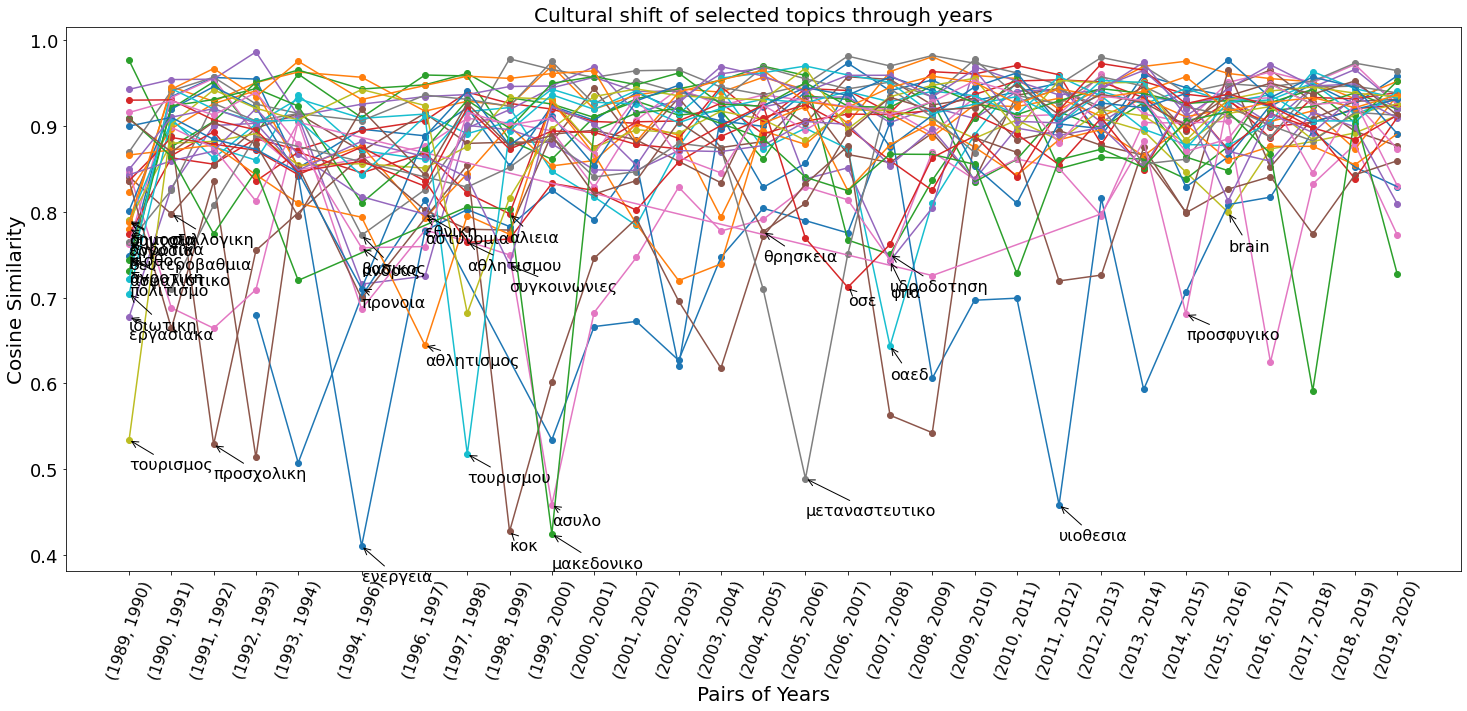

In [43]:
from collections import defaultdict
import matplotlib.pyplot as plt

plot_swift(vouliwatch_topics, df_similarities_2nd_order)